# Code de la partie modélisation et prédiction (problème de classification) du rapport : LARIBI Yanis, KTAIB Achraf.

#  Sommaire

1. [Chargement et pré-traitement des données](#chargement)
2. [Modélisation et prédiction](#modelisation)
   - [Régression logistique multinomiale](#logreg)
   - [Forêt aléatoire (Random Forest)](#rf)
   - [SVM à noyau RBF](#svm)

**On commence par importer les différentes bibliothèques qui nous seront utiles par la suite**

In [46]:
# ============================================================
#  Imports de base
# ============================================================
import os
from pathlib import Path
import tempfile
import warnings
import numpy as np
import pandas as pd
# ============================================================
#  Visualisation et mise en forme
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
# ============================================================
#  Prétraitement et pipeline
# ============================================================
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# ============================================================
#  Réduction de dimension et statistiques
# ============================================================
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, f_oneway, randint, uniform, loguniform
from sklearn.feature_selection import f_classif
# ============================================================
#  Découpage et validation croisée
# ============================================================
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    cross_val_predict,
    GridSearchCV,
    RandomizedSearchCV
)
# ============================================================
#  Modèles de classification
# ============================================================
from sklearn.linear_model import LogisticRegression      # Régression logistique multinomiale
from sklearn.ensemble import RandomForestClassifier      # Forêt aléatoire
from sklearn.svm import SVC                              # SVM à noyau (RBF)
# ============================================================
#  Évaluation des performances
# ============================================================
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
# ============================================================
# Suivi de progression et optimisation
# ============================================================
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Memory

**Changez le path pour charger les données**

In [3]:
path = r"C:\Users\yanis\OneDrive\Bureau\M2MIA\SP\DATA_CHALLENGE\CLASSIFICATION\booking-cancel-prediction"
os.chdir(path)
os.listdir()

['naive_submission.csv',
 'submission1_kernel_rbf_svc_fast.csv',
 'submission1_random_forest.csv',
 'submission1_reglogmult.csv',
 'submission_finale_reglogmult.csv',
 'test_data.csv',
 'train_data.csv']

In [5]:
# chargement des données d'entrainement et de test 
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [6]:
# on transforme la variable is_repeated_guest qui doit etre catégorielle mais qui est percue comme quantitative car prenant des valeurs entières
train_data["is_repeated_guest"] = train_data["is_repeated_guest"].map({
    0: "Yes",
    1: "No"
}).astype("category")

test_data["is_repeated_guest"] = test_data["is_repeated_guest"].map({
    0: "Yes",
    1: "No"
}).astype("category")

In [9]:
print(f" le dataset d'entraînement contient n = {train_data.shape[0]} observations et d = {train_data.shape[1]} variables")
print(f" le dataset de test contient n = {test_data.shape[0]} observations et d = {test_data.shape[1]} variables")

 le dataset d'entraînement contient n = 68898 observations et d = 30 variables
 le dataset de test contient n = 50000 observations et d = 29 variables


**Le jeu de données d'entrainement ne comporte pas la cible, c'est pourquoi il comprend une variable de moins**

In [12]:
# le train/test split est imposé par le challenge
X_train = train_data.drop(columns=["reservation_status"]+["row_id"]+["Unnamed: 0"], errors="ignore")
Y_train = train_data["reservation_status"].astype("int")
X_test = test_data.drop(columns=["row_id"]+["Unnamed: 0"], errors="ignore")

In [14]:
# Identification des variables explicatives numériques et catégorielles
numeric_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Nb features: {X_train.shape[1]} | num: {len(numeric_cols)} | cat: {len(categorical_cols)}")

Nb features: 27 | num: 16 | cat: 11


**Ici, la variable cible, reservation_status est considerée comme numerique pour pouvoir etre utilisée par la suite dans nos modeles mais c'est en principe une variable catégorielle**

In [17]:
print(f"Variables numériques : {list(numeric_cols)}")

Variables numériques : ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [19]:
print(f"Variables catégorielles : {list(categorical_cols)}")

Variables catégorielles : ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type']


***On passe à present à la modélisation, avec trois approches différentes***

# Modèle 1 : Regression logistique multinomiale
-----------------------------------------------

In [192]:
# ------------------------------------------------------------
# Prétraitement 
# ------------------------------------------------------------
# - Standardise les variables numériques pour garantir une mise à l’échelle homogène
#   (important pour les modèles linéaires sensibles aux ordres de grandeur).
# - Encode les variables catégorielles en one-hot pour les rendre exploitables
#   par la régression logistique.
# - Ignore les catégories inconnues rencontrées lors de la prédiction.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [194]:
# ------------------------------------------------------------
# Construction du pipeline 
# ------------------------------------------------------------
# Combine le prétraitement (scaling + encodage) et le modèle de classification
# dans une seule structure pour assurer la reproductibilité.
# - solver="lbfgs" : algorithme quasi-Newton adapté aux problèmes multiclasse.
# - C : hyperparamètre de régularisation (inverse de la pénalisation L2),
#       à ajuster par validation croisée.
# - max_iter : nombre maximal d’itérations pour assurer la convergence.
logreg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs",
        C=1.0,                 # valeur initiale du coefficient de régularisation
        max_iter=1000,         # limite d’itérations pour garantir la convergence
        random_state=42        # graine pour reproductibilité
    ))
])

In [196]:
# ------------------------------------------------------------
# Définition de la grille d’hyperparamètres pour la régularisation (C)
# ------------------------------------------------------------
# L’hyperparamètre C contrôle la force de la régularisation L2 :
# - Petits C → régularisation forte (modèle plus biaisé mais plus stable)
# - Grands C → régularisation faible (modèle plus flexible, risque d’overfitting)
# On explore ici plusieurs ordres de grandeur pour identifier le meilleur compromis
# via validation croisée.
param_grid = {
    "classifier__C": [0.01, 0.1, 0.5, 1, 2, 5, 10]
}

In [202]:
# ------------------------------------------------------------
# Configuration de la recherche d’hyperparamètre par validation croisée
# ------------------------------------------------------------
# Utilise une GridSearchCV pour identifier la meilleure valeur de C
# selon la métrique de F1-score pondéré (pertinente pour classes déséquilibrées).
# - cv=5 : validation croisée à 5 plis pour une estimation robuste.
# - n_jobs=-1 : parallélisation sur tous les cœurs disponibles.
# - verbose=2 : suivi détaillé de la progression.
grid_search = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring="f1_weighted",  # métrique adaptée à la classification multiclasse déséquilibrée
    cv=5,
    n_jobs=-1,
    verbose=2
)

In [204]:
# ------------------------------------------------------------
# Entraînement du modèle avec validation croisée
# ------------------------------------------------------------
# Lance la recherche sur la grille d’hyperparamètres pour identifier
# la meilleure valeur de C selon le F1-score pondéré.
# Le pipeline (prétraitement + modèle) est exécuté à chaque pli de validation.
grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [206]:
# ------------------------------------------------------------
# Résumé des résultats de la recherche d’hyperparamètre
# ------------------------------------------------------------
# Affiche :
# - la meilleure valeur de C identifiée par validation croisée ;
# - le F1-score pondéré moyen associé (moyenne sur les 5 plis).
print("Meilleur paramètre C :", grid_search.best_params_["classifier__C"])
print("Meilleur F1-score (CV) :", grid_search.best_score_)

Meilleur paramètre C : 10
Meilleur F1-score (CV) : 0.8081599567331154


In [210]:
# ------------------------------------------------------------
# Récupération du meilleur modèle entraîné
# ------------------------------------------------------------
# Extraction du pipeline (prétraitement + modèle) correspondant
# à la meilleure configuration trouvée lors de la validation croisée.
best_model_logreg = grid_search.best_estimator_

In [212]:
# ------------------------------------------------------------
# Prédictions sur la base d’entraînement
# ------------------------------------------------------------
# Génère les prédictions sur les données d’apprentissage.
# Attention : ces performances sont optimistes (biaisées),
# car elles ne reflètent pas la capacité de généralisation réelle du modèle.
Y_pred_train = best_model_logreg.predict(X_train)

In [214]:
# ------------------------------------------------------------
# Évaluation robuste par validation croisée (k = 5 plis)
# ------------------------------------------------------------
# Calcule le F1-score pondéré moyen et son écart-type à partir d’une
# validation croisée à 5 plis, fournissant une estimation plus fiable
# de la performance généralisée du modèle.
scores = cross_val_score(best_model_logreg, X_train, Y_train, cv=5, scoring="f1_weighted")
print(f"\nF1-score moyen (CV 5-plis) : {scores.mean():.4f} ± {scores.std():.4f}")


 F1-score moyen en CV : 0.8082 ± 0.0008


In [232]:
# ------------------------------------------------------------
# Résumé des performances sur la base d’entraînement
# ------------------------------------------------------------
# Affiche le rapport de classification complet (précision, rappel, F1-score)
# pour chaque classe ainsi que les moyennes pondérées.
# Ces résultats permettent une première évaluation du comportement du modèle.
print(classification_report(Y_train, Y_pred_train))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     43365
           1       0.81      0.67      0.73     24849
           2       0.60      0.03      0.05       684

    accuracy                           0.82     68898
   macro avg       0.74      0.54      0.55     68898
weighted avg       0.81      0.82      0.81     68898



***La cellule ci-après vise simplement à fournir une table du rapport de classification plus jolie***

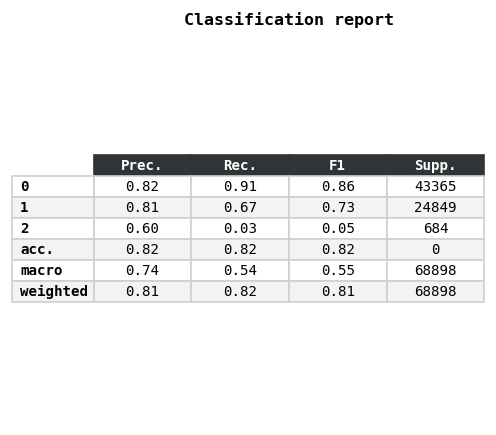

In [244]:
report = classification_report(Y_train, Y_pred_train, output_dict=True)

# DataFrame compact : réordonne + colonnes utiles
df = pd.DataFrame(report).T
rows = [r for r in df.index if r not in ("accuracy","macro avg","weighted avg")]
try:
    rows = sorted(rows, key=lambda x: int(x))
except Exception:
    rows = sorted(rows)
rows = rows + ["accuracy","macro avg","weighted avg"]
df = df.loc[rows, ["precision","recall","f1-score","support"]]

# formats courts
df["precision"] = df["precision"].map(lambda x: "" if pd.isna(x) else f"{x:.2f}")
df["recall"]    = df["recall"].map(   lambda x: "" if pd.isna(x) else f"{x:.2f}")
df["f1-score"]  = df["f1-score"].map( lambda x: "" if pd.isna(x) else f"{x:.2f}")
df["support"]   = df["support"].map(  lambda x: "" if pd.isna(x) else f"{int(x)}")

#  mapping d’index sans .fillna(Index)
mapping = {"accuracy":"acc.", "macro avg":"macro", "weighted avg":"weighted"}
df.index = [mapping.get(str(i), str(i)) for i in df.index]   # fallback = label initial
df.columns = ["Prec.", "Rec.", "F1", "Supp."]

# --- rendu compact carré ---
rcParams.update({"figure.dpi": 120, "savefig.dpi": 300, "font.family": "monospace"})
fig, ax = plt.subplots(figsize=(4.2, 4.2))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    rowLabels=df.index,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8.5)
table.scale(1.0, 1.05)

header_color = "#2f3437"; header_text = "white"
even_color = "#f3f3f3"; odd_color = "#ffffff"; grid_color = "#d0d0d0"

for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text, weight="bold")
        cell.set_edgecolor(header_color)
    else:
        cell.set_facecolor(even_color if r % 2 == 0 else odd_color)
        cell.set_edgecolor(grid_color)
        if c == -1:
            cell.set_text_props(weight="bold")

ax.set_title("Classification report", fontsize=10, fontweight="bold", pad=6)

#plt.savefig("report_reg_log_mult.png", bbox_inches="tight", facecolor="white")
plt.show()


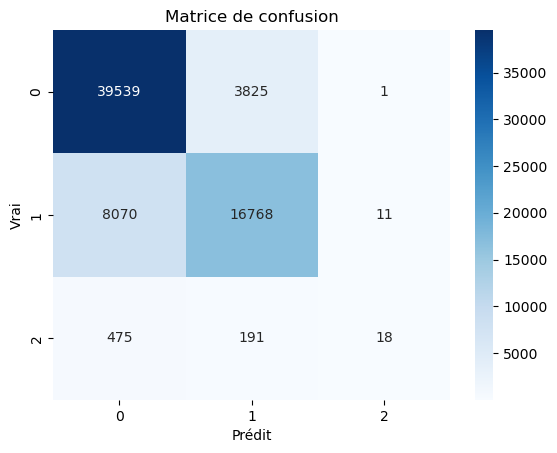

In [226]:
# ------------------------------------------------------------
# Visualisation de la matrice de confusion (base d’entraînement)
# ------------------------------------------------------------
# Permet de visualiser la répartition des prédictions correctes et des erreurs
# entre les différentes classes. Donne une idée fine des confusions éventuelles
# entre classes voisines.
cm = confusion_matrix(Y_train, Y_pred_train)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion – Régression logistique multinomiale", fontweight="bold")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# Sauvegarde pour intégration au rapport
#plt.savefig("confusion_matrix_reglogmult.png", bbox_inches="tight", facecolor="white")
plt.show()


In [224]:
# Afin d'évaluer la capacité de généralisation de notre modèle (erreur de généralisation e_in) 
# et on prédit les etiquettes sur la base de test et on submit sur kaggle pour calculer le F1 score avec les vraies etiquettes de test
Y_pred = best_model_logreg.predict(X_test)
submission = test_data["row_id"]
df_logreg = pd.DataFrame({"row_id": submission})  # on crée un DF 
df_logreg["reservation_status"] = Y_pred_test.astype(int)   # nom de colonne à adapter selon Kaggle
df_logreg
df_logreg.to_csv("submission_finale_reglogmult.csv", index=False)

# Modèle 2 : Forêt aléatoire
-----------------------------

In [21]:
# Création d'un répertoire temporaire pour stocker les fichiers intermédiaires (caché automatiquement après exécution)
tmpdir = tempfile.mkdtemp()

# Préprocessing : pas de scaling num ; OHE cat (sparse) 
preprocessor = ColumnTransformer([
    ("num", "passthrough", numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="if_binary"), categorical_cols),
], sparse_threshold=0.3)


In [23]:
# ------------------------------------------------------------
# Définition du modèle de base Random Forest
# ------------------------------------------------------------
rf_base = RandomForestClassifier(
    n_estimators=200,                 # nombre d’arbres dans la forêt
    max_depth=None,                   # profondeur non contrainte (croissance complète des arbres)
    max_features="sqrt",              # nombre de variables considérées à chaque split
    min_samples_split=2,              # nombre minimal d’échantillons pour diviser un nœud
    min_samples_leaf=1,               # nombre minimal d’échantillons dans une feuille
    bootstrap=True,                   # échantillonnage avec remise (bagging)
    class_weight="balanced_subsample",# pondération automatique selon la fréquence des classes
    oob_score=False,                  # pas d’évaluation hors sac (désactivée ici)
    max_samples=0.7,                  # sous-échantillonnage (70%) par arbre pour accélérer l’apprentissage
    n_jobs=-1,                        # utilisation de tous les cœurs disponibles
    random_state=42                   # graine de reproductibilité
)

In [25]:
# Construction du pipeline combinant prétraitement et modèle Random Forest
# Le paramètre 'memory' permet de mettre en cache les étapes intermédiaires 
# pour accélérer la recherche d’hyperparamètres lors de la cross-validation.
pipe = Pipeline([
    ("prep", preprocessor),   # étape de prétraitement (encodage / scaling)
    ("rf", rf_base)           # modèle Random Forest
], memory=Memory(tmpdir))

# ------------------------------------------------------------
# Définition de la grille de recherche aléatoire (RandomizedSearchCV)
# ------------------------------------------------------------
# Les plages d’hyperparamètres explorées couvrent un large spectre de complexité
# afin d’équilibrer performance, généralisation et coût de calcul.
param_distributions = {
    "rf__n_estimators": randint(150, 251),        # nombre d’arbres
    "rf__max_depth": [None, 16, 24],              # profondeur maximale des arbres
    "rf__max_features": ["sqrt", "log2", 0.5],    # stratégie de sélection des features
    "rf__min_samples_split": randint(2, 8),       # min. d’échantillons pour un split
    "rf__min_samples_leaf": [1, 2, 5],            # min. d’échantillons par feuille
    "rf__max_samples": [0.6, 0.7, 0.8],           # proportion d’échantillons bootstrap
}

In [27]:
# Définition de la stratégie de validation croisée stratifiée (3 plis)
# Assure une répartition équilibrée des classes dans chaque pli
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [40]:
# Configuration de la recherche aléatoire d’hyperparamètres (RandomizedSearchCV)
# Explore un sous-ensemble aléatoire de combinaisons dans la grille définie ci-dessus
rs = RandomizedSearchCV(
    estimator=pipe,                      # pipeline complet (prétraitement + modèle)
    param_distributions=param_distributions,  # grille d’hyperparamètres à explorer
    n_iter=24,                           # nombre total de combinaisons testées
    scoring="f1_weighted",               # métrique d’évaluation (pondérée selon les classes)
    cv=cv,                               # stratégie de validation croisée (StratifiedKFold)
    n_jobs=1,                            # exécution séquentielle (pour suivi de progression)
    verbose=3,                           # niveau de verbosité (affiche le suivi des fits)
    random_state=42                      # graine pour reproductibilité
)

In [48]:
# ------------------------------------------------------------
# Entraînement du modèle avec recherche aléatoire d’hyperparamètres
# ------------------------------------------------------------

# Masque les avertissements liés aux catégories inconnues pendant la validation croisée
# (dus aux splits contenant des modalités absentes dans certains plis)
warnings.filterwarnings("ignore", message="Found unknown categories", category=UserWarning)

# Lancement de la recherche aléatoire (fit sur les données d’entraînement)
rs.fit(X_train, Y_train)

# Affichage du meilleur score de validation croisée et des hyperparamètres optimaux
print("Meilleur score (validation croisée, f1_weighted) :", rs.best_score_)
print("Meilleurs hyperparamètres trouvés :", rs.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3] END rf__max_depth=24, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=170;, score=0.849 total time=   9.6s
[CV 2/3] END rf__max_depth=24, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=170;, score=0.853 total time=  10.2s
[CV 3/3] END rf__max_depth=24, rf__max_features=sqrt, rf__max_samples=0.8, rf__min_samples_leaf=5, rf__min_samples_split=6, rf__n_estimators=170;, score=0.851 total time=  10.6s
[CV 1/3] END rf__max_depth=24, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_leaf=5, rf__min_samples_split=4, rf__n_estimators=224;, score=0.827 total time=   6.8s
[CV 2/3] END rf__max_depth=24, rf__max_features=log2, rf__max_samples=0.8, rf__min_samples_leaf=5, rf__min_samples_split=4, rf__n_estimators=224;, score=0.832 total time=   6.8s
[CV 3/3] END rf__max_depth=24, rf__max_features=l

In [50]:
# ------------------------------------------------------------
# Réentraînement final du modèle avec les meilleurs hyperparamètres
# ------------------------------------------------------------
# On réutilise le meilleur pipeline trouvé par RandomizedSearchCV,
# en augmentant le nombre d’arbres et en activant le score hors sac (OOB)
# pour une meilleure estimation interne de la performance.
final_model = rs.best_estimator_
final_model.named_steps["rf"].set_params(
    n_estimators=600,   # plus d’arbres pour stabiliser les prédictions
    oob_score=True,     # activation de l’évaluation hors sac
    max_samples=None    # utilisation de l’ensemble complet pour chaque arbre
)
# Entraînement final sur la totalité des données d’apprentissage
final_model.fit(X_train, Y_train)

,steps,"[('prep', ...), ('rf', ...)]"
,transform_input,None
,memory,Memory(locati...d300dq\joblib)
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
# ------------------------------------------------------------
# Génération des prédictions sur la base d’entraînement
# ------------------------------------------------------------
# Permet d’évaluer les performances du modèle final sur les données vues lors de l’apprentissage
Y_pred_train = final_model.predict(X_train)

In [54]:
print("\n--- Résultats sur la base d'entraînement ---")
print(classification_report(Y_train, Y_pred_train, digits=3))


--- Résultats sur la base d'entraînement ---
              precision    recall  f1-score   support

           0      0.998     0.996     0.997     43365
           1      0.995     0.996     0.995     24849
           2      0.895     1.000     0.945       684

    accuracy                          0.996     68898
   macro avg      0.963     0.997     0.979     68898
weighted avg      0.996     0.996     0.996     68898



***La cellule ci-après vise simplement à fournir une table du rapport de classification plus jolie***

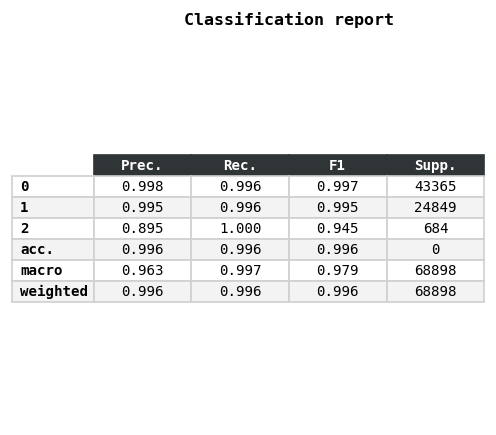

In [74]:
report = classification_report(Y_train, Y_pred_train, output_dict=True)

# DataFrame compact : réordonne + colonnes utiles
df = pd.DataFrame(report).T
rows = [r for r in df.index if r not in ("accuracy","macro avg","weighted avg")]
try:
    rows = sorted(rows, key=lambda x: int(x))
except Exception:
    rows = sorted(rows)
rows = rows + ["accuracy","macro avg","weighted avg"]
df = df.loc[rows, ["precision","recall","f1-score","support"]]

# formats courts
df["precision"] = df["precision"].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["recall"]    = df["recall"].map(   lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["f1-score"]  = df["f1-score"].map( lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["support"]   = df["support"].map(  lambda x: "" if pd.isna(x) else f"{int(x)}")

# mapping d’index sans .fillna(Index)
mapping = {"accuracy":"acc.", "macro avg":"macro", "weighted avg":"weighted"}
df.index = [mapping.get(str(i), str(i)) for i in df.index]   # fallback = label initial
df.columns = ["Prec.", "Rec.", "F1", "Supp."]

# --- rendu compact carré ---
rcParams.update({"figure.dpi": 120, "savefig.dpi": 300, "font.family": "monospace"})
fig, ax = plt.subplots(figsize=(4.2, 4.2))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    rowLabels=df.index,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8.5)
table.scale(1.0, 1.05)

header_color = "#2f3437"; header_text = "white"
even_color = "#f3f3f3"; odd_color = "#ffffff"; grid_color = "#d0d0d0"

for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text, weight="bold")
        cell.set_edgecolor(header_color)
    else:
        cell.set_facecolor(even_color if r % 2 == 0 else odd_color)
        cell.set_edgecolor(grid_color)
        if c == -1:
            cell.set_text_props(weight="bold")

ax.set_title("Classification report", fontsize=10, fontweight="bold", pad=6)

#plt.savefig("report_rf.png", bbox_inches="tight", facecolor="white")
plt.show()

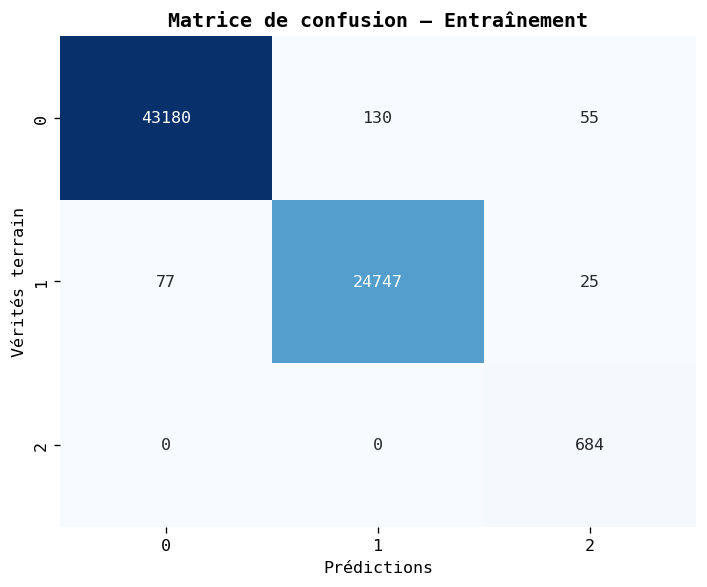

In [76]:
# ------------------------------------------------------------
# Visualisation de la matrice de confusion (base d'entraînement)
# ------------------------------------------------------------
# Permet de visualiser la répartition des prédictions correctes et des erreurs par classe
plt.figure(figsize=(6, 5))
cm = confusion_matrix(Y_train, Y_pred_train)

# Affichage sous forme de carte de chaleur
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Matrice de confusion – Entraînement", fontweight="bold")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.tight_layout()

# Sauvegarde de la figure pour intégration au rapport
#plt.savefig("confusion_matrix_rf_train.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


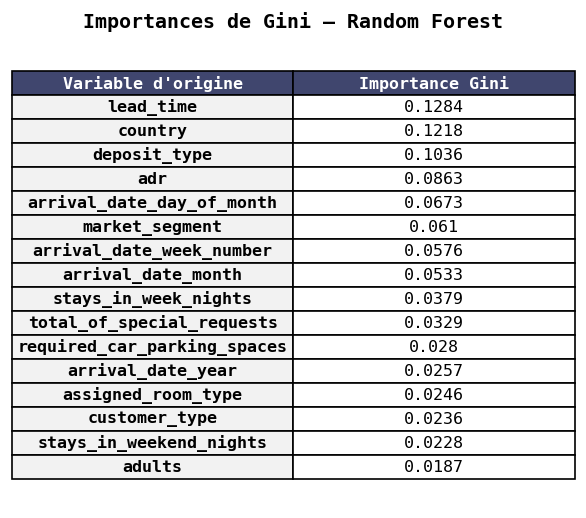

In [78]:
# ------------------------------------------------------------
# Extraction et visualisation des importances de Gini (Random Forest)
# ------------------------------------------------------------

# --- Récupération du modèle et du préprocesseur depuis le pipeline final
rf_inner = final_model.named_steps["rf"]    # modèle Random Forest
prep = final_model.named_steps["prep"]      # étape de prétraitement (encodage / scaling)

# --- Récupération des noms de variables après transformation
num_features = list(numeric_cols)
cat_features = list(prep.named_transformers_["cat"].get_feature_names_out(categorical_cols))
feature_names = num_features + cat_features

# --- Création d’un DataFrame contenant les importances individuelles (Gini)
importances = pd.DataFrame({
    "Variable": feature_names,
    "Importance Gini": rf_inner.feature_importances_
}).sort_values(by="Importance Gini", ascending=False).reset_index(drop=True)

# --- Regroupement des dummies pour retrouver la variable d’origine (lisibilité accrue)
def origin_from_transformed(name):
    if name in num_features:
        return name
    base = name.split("_", 1)[0]
    cands = [c for c in categorical_cols if name.startswith(c + "_")]
    return max(cands, key=len) if cands else base

# Agrégation des importances par variable d’origine
importances["Variable d'origine"] = importances["Variable"].apply(origin_from_transformed)
importances_grouped = (
    importances.groupby("Variable d'origine", as_index=False)["Importance Gini"]
    .sum()
    .sort_values("Importance Gini", ascending=False)
    .reset_index(drop=True)
)

# --- Sélection des 16 variables les plus importantes
df = importances_grouped.head(16).round(4)

# ------------------------------------------------------------
# Construction du tableau final "journal style"
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5.5, 5))  # format carré et compact
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    loc="center"
)

# --- Mise en forme visuelle élégante et homogène
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.1, 1.2)

for (row, col), cell in table.get_celld().items():
    if row == 0:  # en-tête
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor("#40466e")
    elif col == 0:  # colonne des noms de variables
        cell.set_text_props(weight='bold')
        cell.set_facecolor("#f2f2f2")
    else:  # cellules de valeurs
        cell.set_facecolor("white")

plt.title("Importances de Gini – Random Forest", fontsize=12, fontweight="bold", pad=10)

# --- Sauvegarde du tableau pour insertion dans le rapport
#plt.savefig("rf_gini_importances_table.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

In [68]:
# ------------------------------------------------------------
# Vérification du score hors sac (OOB) – évaluation interne
# ------------------------------------------------------------
# Le score OOB (Out-Of-Bag) fournit une estimation interne de la performance
# obtenue à partir des observations non incluses dans l’échantillon bootstrap
# de chaque arbre, sans nécessiter de jeu de validation supplémentaire.
rf_inner = final_model.named_steps["rf"]
if hasattr(rf_inner, "oob_score_"):
    print(f"Score OOB estimé : {rf_inner.oob_score_:.4f}")

Score OOB estimé : 0.8834


In [72]:
# ------------------------------------------------------------
# Génération des prédictions sur la base de test et préparation du fichier Kaggle
# ------------------------------------------------------------
# Objectif : évaluer la capacité de généralisation du modèle sur des données non vues
# (erreur de généralisation e_out). Les vraies étiquettes de test étant cachées,
# l’évaluation finale du F1-score est réalisée via la soumission sur Kaggle.

# Prédictions sur la base de test
Y_pred_test = final_model.predict(X_test)

# Création du DataFrame de soumission (format attendu par Kaggle)
submission = test_data["row_id"]
df_rf = pd.DataFrame({"row_id": submission})
df_rf["reservation_status"] = Y_pred_test.astype(int)  # nom de colonne conforme au format Kaggle

# Aperçu et sauvegarde du fichier de soumission
df_rf.to_csv("submission_finale_rf.csv", index=False)

# Modèle 3 : SVM à noyau (RBF) étendu à la multi-classification (OvO)
-------------------------------------------------------------

In [ ]:
# Création d’un répertoire temporaire pour mettre en cache les étapes de prétraitement
# (utile pour accélérer les réexécutions du pipeline lors de la validation croisée du SVM)
cache_dir = tempfile.mkdtemp(prefix="svm_cache_")

In [ ]:
# Définition du préprocesseur pour le pipeline SVM
# - Standardise les variables numériques (important pour la mesure de distance du noyau RBF)
# - Encode les variables catégorielles en one-hot (avec gestion des catégories inconnues)
# - Supprime les autres colonnes éventuelles
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), categorical_cols),
    ],
    remainder="drop"
)

In [ ]:
# Définition du classifieur SVM à noyau RBF
# - kernel="rbf" : permet de modéliser des frontières de décision non linéaires
# - decision_function_shape="ovo" : extension One-vs-One pour la classification multiclasse
# - probability=False : désactive le calcul des probabilités (gain de temps)
# - random_state=42 : graine pour assurer la reproductibilité
svc = SVC(kernel="rbf", decision_function_shape="ovo", probability=False, random_state=42)

In [ ]:
# Construction du pipeline complet pour le SVM
# Combine le prétraitement (scaling + encodage) et le classifieur SVM dans une même structure.
# Le paramètre 'memory' permet de mettre en cache les étapes intermédiaires
# afin d’accélérer la validation croisée et les réexécutions.
pipe = Pipeline(
    steps=[("prep", preprocessor), ("clf", svc)],
    memory=cache_dir
)

In [ ]:
# Création d’un sous-échantillon stratifié (40% du jeu d’entraînement)
# Permet de réduire le temps de calcul lors de la recherche d’hyperparamètres
# tout en conservant la même proportion de classes que dans l’ensemble initial.
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.4, random_state=42)
idx_sub, _ = next(sss.split(X_train, y_train))

In [ ]:
# Définition d’une recherche aléatoire d’hyperparamètres pour le SVM (RandomizedSearchCV)
# Exploration rapide sur des plages logarithmiques pour :
# - C : coefficient de régularisation (contrôle la marge / le sur-apprentissage)
# - gamma : paramètre du noyau RBF (contrôle la flexibilité de la frontière de décision)
# - class_weight : gestion optionnelle du déséquilibre de classes
param_dist = {
    "clf__C": loguniform(1e-1, 1e2),       # plage [0.1, 100]
    "clf__gamma": loguniform(1e-3, 1e0),   # plage [1e-3, 1]
    "clf__class_weight": [None, "balanced"],
}

In [ ]:
# Définition de la stratégie de validation croisée stratifiée (3 plis)
# Garantit une répartition équilibrée des classes dans chaque pli,
# ce qui est essentiel pour une évaluation fiable du SVM.
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Configuration de la recherche aléatoire d’hyperparamètres pour le SVM
# - Explore 24 combinaisons aléatoires d’hyperparamètres (C, gamma, class_weight)
# - Évalue chaque combinaison selon le F1-score pondéré avec validation croisée stratifiée
# - Utilise tous les cœurs disponibles pour accélérer les calculs
# - Refit automatique du meilleur modèle sur l’ensemble complet d’entraînement
rsearch = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=24,                  # nombre total de combinaisons testées
    scoring="f1_weighted",      # métrique d’évaluation principale
    cv=cv,                      # validation croisée à 3 plis
    n_jobs=-1,                  # parallélisation sur tous les cœurs disponibles
    random_state=42,            # graine de reproductibilité
    verbose=1,                  # suivi textuel de la progression
    refit=True                  # réentraînement du meilleur modèle après la recherche
)

In [ ]:
# ------------------------------------------------------------
# Entraînement du SVM sur le sous-échantillon et recherche d’hyperparamètres
# ------------------------------------------------------------
# Lancement de la recherche aléatoire sur 40% du jeu d’entraînement
# afin d’identifier rapidement la combinaison (C, gamma, class_weight) la plus performante.
rsearch.fit(X_sub, y_sub)

# Affichage des meilleurs hyperparamètres et du score F1 moyen obtenu en validation croisée
print("Meilleurs hyperparamètres (sur sous-échantillon) :", rsearch.best_params_)
print("Meilleur F1 (CV, sous-échantillon) :", f"{rsearch.best_score_:.4f}")

In [ ]:
# ------------------------------------------------------------
# Réentraînement final du SVM sur l’ensemble complet d’entraînement
# ------------------------------------------------------------
# On récupère le meilleur pipeline trouvé lors de la recherche aléatoire,
# puis on désactive le cache (inutile après la phase d’optimisation).
# Le modèle est ensuite réentraîné sur toutes les données d’apprentissage
# avec les hyperparamètres optimaux.
best_clf = rsearch.best_estimator_.set_params(memory=None)
best_clf.fit(X_train, y_train)

In [ ]:
# ------------------------------------------------------------
# Évaluation OOF (Out-Of-Fold) pour un diagnostic rapide
# ------------------------------------------------------------
# Génère des prédictions "hors pli" via une validation croisée à 3 plis,
# permettant d’estimer la performance du modèle sur des données non vues,
# sans avoir recours à un jeu de validation séparé.
y_oof = cross_val_predict(best_clf, X_train, y_train, cv=3, n_jobs=-1)

print("\nRapport OOF :")

In [ ]:
# ------------------------------------------------------------
# Visualisation de la matrice de confusion (prédictions OOF)
# ------------------------------------------------------------
# Permet d’analyser la répartition des prédictions correctes et des erreurs
# obtenues lors de la validation croisée (approche Out-Of-Fold),
# donnant un aperçu réaliste des performances de généralisation du SVM.
cm = confusion_matrix(y_train, y_oof)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Matrice de confusion – Validation croisée (OOF)", fontweight="bold")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")

# Sauvegarde optionnelle pour le rapport
# plt.savefig("confusion_matrix_svm.png", bbox_inches="tight", facecolor="white")
plt.show()

***La cellule ci-après vise simplement à fournir une table du rapport de classification plus jolie***

In [ ]:
report = classification_report(Y_train, Y_oof, output_dict=True)

# DataFrame compact : réordonne + colonnes utiles
df = pd.DataFrame(report).T
rows = [r for r in df.index if r not in ("accuracy","macro avg","weighted avg")]
try:
    rows = sorted(rows, key=lambda x: int(x))
except Exception:
    rows = sorted(rows)
rows = rows + ["accuracy","macro avg","weighted avg"]
df = df.loc[rows, ["precision","recall","f1-score","support"]]

# formats courts
df["precision"] = df["precision"].map(lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["recall"]    = df["recall"].map(   lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["f1-score"]  = df["f1-score"].map( lambda x: "" if pd.isna(x) else f"{x:.3f}")
df["support"]   = df["support"].map(  lambda x: "" if pd.isna(x) else f"{int(x)}")

# mapping d’index sans .fillna(Index)
mapping = {"accuracy":"acc.", "macro avg":"macro", "weighted avg":"weighted"}
df.index = [mapping.get(str(i), str(i)) for i in df.index]   # fallback = label initial
df.columns = ["Prec.", "Rec.", "F1", "Supp."]

# --- rendu compact carré ---
rcParams.update({"figure.dpi": 120, "savefig.dpi": 300, "font.family": "monospace"})
fig, ax = plt.subplots(figsize=(4.2, 4.2))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    rowLabels=df.index,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(8.5)
table.scale(1.0, 1.05)

header_color = "#2f3437"; header_text = "white"
even_color = "#f3f3f3"; odd_color = "#ffffff"; grid_color = "#d0d0d0"

for (r, c), cell in table.get_celld().items():
    if r == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(color=header_text, weight="bold")
        cell.set_edgecolor(header_color)
    else:
        cell.set_facecolor(even_color if r % 2 == 0 else odd_color)
        cell.set_edgecolor(grid_color)
        if c == -1:
            cell.set_text_props(weight="bold")

ax.set_title("Classification report OOF", fontsize=10, fontweight="bold", pad=6)

#plt.savefig("report_svm.png", bbox_inches="tight", facecolor="white")
plt.show()

In [ ]:
# ------------------------------------------------------------
# Prédictions finales sur la base de test et création du fichier de soumission Kaggle
# ------------------------------------------------------------
# Le modèle SVM final est utilisé pour prédire les étiquettes sur l’ensemble de test.
# Les vraies étiquettes étant cachées, la performance (F1-score) sera calculée
# directement par la plateforme Kaggle après soumission du fichier.
Y_pred_test = best_clf.predict(X_test)

# Construction du DataFrame de soumission conforme au format Kaggle
submission = test_data["row_id"]
df_rf = pd.DataFrame({"row_id": submission})
df_rf["reservation_status"] = Y_pred_test.astype(int)  # nom de colonne attendu sur Kaggle

# Sauvegarde du fichier CSV pour la soumission finale
#df_rf.to_csv("submission_finale_svm.csv", index=False)